## Title
Variational Auto-Encoder From scratch

## Description :
The goal of this exercise is to build a VAE from scratch to reconstruct images of the MNIST dataset.

<img src="../fig/fig1.png" style="width: 500px;">

In [16]:
# Import required libraries 

import numpy as np
import pandas as p
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
from scipy.stats import norm
%matplotlib inline 

In [17]:
# Get a subset of the mnist data
# x_train, x_test = np.load('mnist_mini_train.npy'), np.load('mnist_mini_test.npy')

In [18]:
from sklearn.model_selection import train_test_split

mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)= mnist.load_data()
x_train,x_test,y_train, y_test = train_test_split(x_test, y_test, test_size=0.3)

## Preprocessing Images

As per the original paper on VAE [Kingma et al](https://arxiv.org/abs/1312.6114), we make an *Independent Bernoulli* assumption on all of the pixels of our image.

However, the original MNIST image pixel values are **not** labels but values between 0 & 255.

Hence we must convert the individual pixel values to a Bernoulli distribution.

We can do that by choosing a threshold, and assigning value 1 if the pixel value is above the threshold, else zero.

In [19]:
# Function to 
# 1. Change dimensions
# 2. Change datatype
def binary_preprocess(imageset):
    imageset = imageset.reshape(imageset.shape[0],28,28,1)/255.
    return np.where(imageset > .5, 1.0,0.0).astype('float32')

In [20]:
# Pre-processed images to satisfy the Independent Bernoulli condition
x_train_images = binary_preprocess(x_train)
x_test_images = binary_preprocess(x_test)

In [21]:
# Dataset object to get a mini-batch
batch_size = 100
train_size = x_train_images.shape[0]
latent_size = 2
input_shape = (28,28,1)

In [22]:
# Model encoder architecture 
encoder = tf.keras.Sequential(
          [
            tf.keras.layers.InputLayer(input_shape=(28,28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(32,activation='relu'),              
            # No activation
            tf.keras.layers.Dense(4),
        ]
    )

In [35]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 104740 (409.14 KB)
Trainable params: 104740 (409.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Model decoder architecture 
decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),              
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),            
            tf.keras.layers.Dense(784,activation='sigmoid'),
            tf.keras.layers.Reshape((28,28,1))
        ]
    )

In [45]:
# Encoding step
# Note: We use logvariance instead of variance 

# Get the mean and the logvariance
def encode(encoder,x):
    activations = encoder(x)
    mean, logvariance = tf.split(activations,num_or_size_splits=2,axis=1)
    # Splits a tensor value into a list of sub tensors.
    # it splits value along the dimension axis into num_or_size_splits smaller tensors.
    print(activations.shape, mean.shape)
    return mean,logvariance

# Reparametrization step
def sample(mu, logvariance):
    
    # Here we sample from N(0,1)
    e = tf.random.normal(shape=mu.shape)
    return e * tf.exp(logvariance/2) + mu

# Combine the autoencoder
def autoencoder(encoder,decoder,x):
    mean,logvariance = encode(encoder,x)
    z = sample(mean,logvariance)
    # print(mean.shape, z.shape)
    output = decoder(z)
    return output

## Log space
We will be using log loss. This is because numerically is more stable. 

## Log Normal PDF

$$f(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$$

$$ \log f(x)=  -\log(\sigma) -\frac{1}{2} \left(\log(2 \pi) -(\frac{x-\mu}{\sigma})^2)\right)$$



## KL Divergence Analytical form
We will use this analytical form to compute the KL divergence

$\mathrm{KL} [ q_{\phi}(\mathbf{z} | \mathbf{x}) || p(\mathbf{z}) ]
= - \frac{1}{2} \sum_{k=1}^K { 1 + \log \sigma_k^2 - \mu_k^2 - \sigma_k^2 }$

where $K$ is the number of hidden dimensions. 

## Reconstruction loss:
*Binary CrossEntropy*

$H_{p}=-\frac{1}{N} \sum_{i=1}^{N} \sum_j y_{ij} \cdot \log \left(p\left(y_{ij}\right)\right)+\left(1-y_{ij}\right) \cdot \log \left(1-p\left(y_{ij}\right)\right)$

where $p(y_i)$ is the output of the NN, $N$ is the number of images and $j$ represents the pixel. 

In [25]:
# Quick way to get the log likelihood of a normal distribution
def log_normal_pdf(value, mean, logvariance, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    logpdf = -(logvariance + log_2pi + (value - mean)**2. * tf.exp(logvariance))/2
    # should be -(logvariance + log_2pi + (value - mean)**2. / tf.exp(logvariance))/2
    return tf.reduce_sum(logpdf,axis=1)
# Computes the sum of elements across dimensions of a tensor.

    

# Loss over the assumed distribution(qz_x) and the prior(pz)
def analytical_kl(encoder,x):
    mean, logvariance = encode(encoder,x)
    # tf.reduce_sum is over the hidden dimensions
    lossval = tf.reduce_sum(-0.5*(1 + logvariance - tf.square(mean) - tf.exp(logvariance)),axis=-1)
    return tf.reduce_mean(lossval)

# This is now binary cross entropy
# Crucially, observe that we sum across the image dimensions
# and only take the mean in the images dimension
def reconstruction_loss(encoder,decoder,x):
    x_pred = autoencoder(encoder,decoder,x)
    loss = tf.keras.losses.binary_crossentropy(x,x_pred)
    # tf.reduce_sum is over all pixels and tf.reduce_mean is over all images
    return tf.reduce_mean(tf.reduce_sum(loss,axis=[1,2]))

In [29]:
# Instantiate an optimizer with a learning rate
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-3)

# Define number of epochs
num_epochs = 300


# Loop over the required number of epochs
for i in range(num_epochs):
    for j in range(int(train_size/batch_size)):
        
        # Randomly choose a minitbatch
        x_train_batch = x_train_images[np.random.choice(train_size,batch_size)]
        
        # Open the gradienttape to map the computational graph
        with tf.GradientTape(persistent=True) as t:
            # persistent = True, This allows multiple calls to the gradient() method as resources are released when the tape object is garbage collected
            # garbage collection" unused or no-longer-needed objects are automatically identified and released from memory to free up resources.
            
            decoder_output = autoencoder(encoder,decoder,x_train_batch)

            L1 = reconstruction_loss(encoder,decoder,x_train_batch)
            L2 = analytical_kl(encoder,x_train_batch)
            # Adding the reconstruction loss and KL divergence
            loss = L1 + L2
            
        # We take the gradients with respect to the decoder    
        gradients1 = t.gradient(loss, decoder.trainable_weights)
        # We take the gradients with respect to the encoder        
        gradients2 = t.gradient(loss, encoder.trainable_weights)
        
        # We update the weights of the decoder
        optimizer.apply_gradients(zip(gradients1, decoder.trainable_weights))
        # We update the weights of the decoder        
        optimizer.apply_gradients(zip(gradients2, encoder.trainable_weights))
    
    # We display the loss after every 10 epochs
    if i+1%10==0:     
        print(f'Loss at epoch {i+1} is {loss:.2f}, KL Divergence is {L2:.2f}')


## Visualize stochastic predictions

In [30]:
# We choose a text sample index
test_sample = 10

# We make a prediction
# NOTE: Since we did not add a sigmoid activation,
# We must specify it now to convert logits to probabilities
pred = autoencoder(encoder,decoder,x_test_images[test_sample:test_sample+1])

# We make class predictions for each pixel (ON or OFF)
pred = np.where(pred>0.5,1,0)
pred = pred.squeeze()
pred.shape

(28, 28)

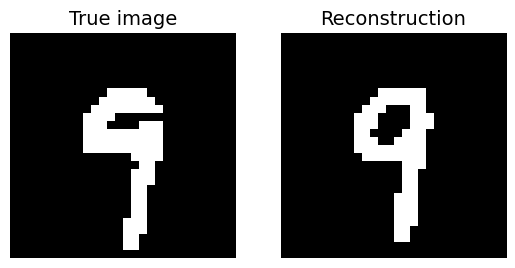

In [31]:
# We plot the reconstruction with the true input 
fig, ax = plt.subplots(1,2)
ax[0].imshow(x_test_images[test_sample].squeeze(),cmap='gray')
ax[1].imshow(pred,cmap='gray')
ax[0].set_title('True image',fontsize=14)
ax[1].set_title('Reconstruction',fontsize=14);
ax[0].axis('off');
ax[1].axis('off');
plt.show()

## Optional segment 
### Decoding the prior distribution

- We expect a continuous latent space representation

In [55]:
z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
np.array(np.meshgrid(z1, z2)).shape

(2, 15, 15)

In [60]:
np.dstack(np.meshgrid(z1, z2)).shape
# Stack arrays in sequence depth wise (along third axis).

(15, 15, 2)

8/8 [==============================] - 0s 805us/step


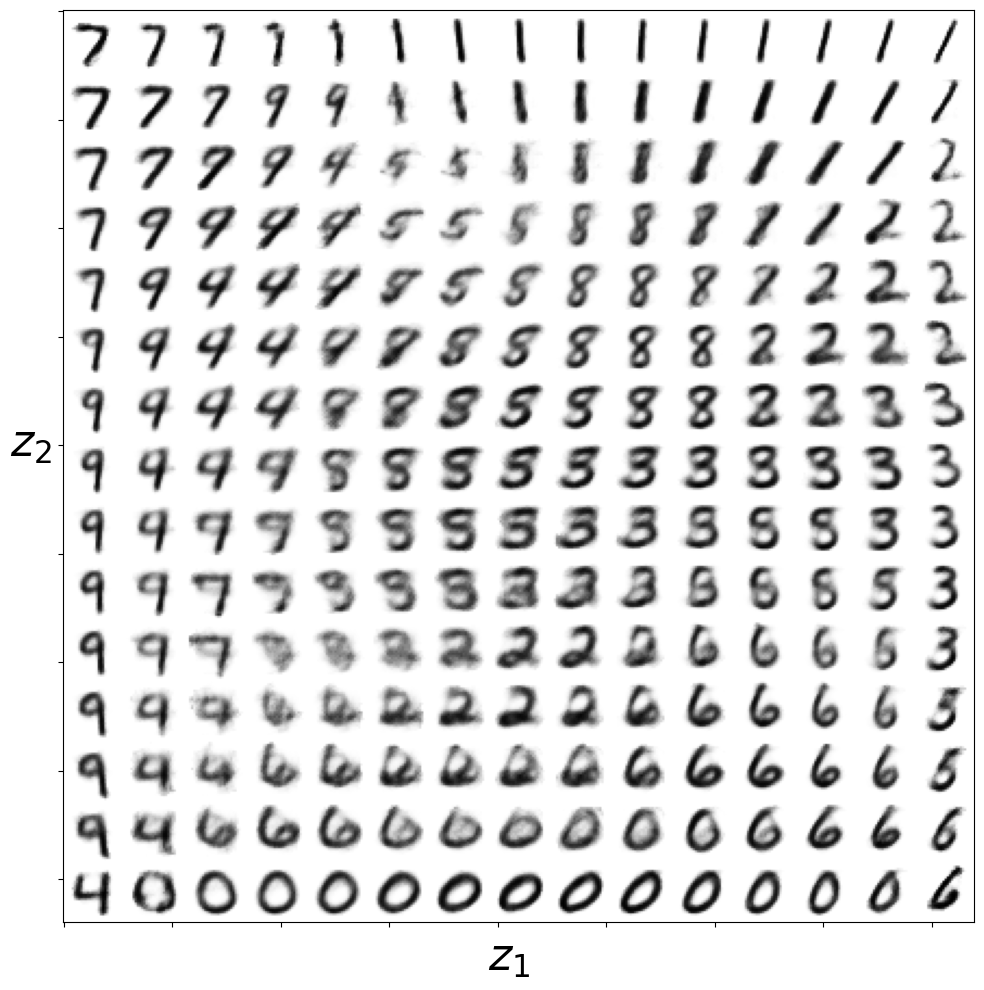

In [32]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

latent_dim = 2

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
# CDF Cumulative Distribution Function

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = tf.sigmoid(decoder.predict(z_grid.reshape(n*n, latent_dim))).numpy() \
                     .reshape(n, n, digit_size, digit_size)
# the input dim for the decoder is (2, ), 2 means 2 dimensions of z

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(np.block(list(map(list, x_pred_grid))),cmap='binary')
# np.block Assemble an nd-array from nested lists of blocks. does not work on np.array
# first have to convert each element in x_pred_grid into a list
# The map function returns an iterator, so the list constructor is used to convert the iterator into a list.

# ax.axis('off')
ax.set_xlabel('$z_1$  ', fontsize=32)
ax.set_ylabel('$z_2$   ', fontsize=32,rotation=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
plt.tight_layout()

In [82]:
x_pred_grid

array([[[[0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         ...,
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ]],

        [[0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5       ],
         ...,
         [0.5       , 0.5       , 0.5       , ..., 0.5       ,
          0.5       , 0.5

In [83]:
list(map(list, x_pred_grid))

[[array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       ],
         [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
          0.5       , 0.5       , 0.5       , 0.5       , 0.5     

In [46]:
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-3)

# Define number of epochs
num_epochs = 1


# Loop over the required number of epochs
for i in range(num_epochs):
    for j in range(int(train_size/batch_size)):
        
        # Randomly choose a minitbatch
        x_train_batch = x_train_images[np.random.choice(train_size,batch_size)]
        
        # Open the gradienttape to map the computational graph
        with tf.GradientTape(persistent=True) as t:
            # persistent = True, This allows multiple calls to the gradient() method as resources are released when the tape object is garbage collected
            # garbage collection" unused or no-longer-needed objects are automatically identified and released from memory to free up resources.
            
            decoder_output = autoencoder(encoder,decoder,x_train_batch)

            L1 = reconstruction_loss(encoder,decoder,x_train_batch)
            L2 = analytical_kl(encoder,x_train_batch)
            # Adding the reconstruction loss and KL divergence
            loss = L1 + L2
            
        # We take the gradients with respect to the decoder    
        gradients1 = t.gradient(loss, decoder.trainable_weights)
        # We take the gradients with respect to the encoder        
        gradients2 = t.gradient(loss, encoder.trainable_weights)
        
        # We update the weights of the decoder
        optimizer.apply_gradients(zip(gradients1, decoder.trainable_weights))
        # We update the weights of the decoder        
        optimizer.apply_gradients(zip(gradients2, encoder.trainable_weights))
    
    # We display the loss after every 10 epochs


(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (100, 2)
(100, 4) (